In [41]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LogisticRegression

sys.path.append(r'C:\Users\DerDo\Desktop\fantasy_basketball_project')
from functions import *

In [2]:
data = get_player_data('jokicni01', '2025')

season_data = data[1]
missed_data = data[0]

In [4]:
predictions = predict_fantasy_score(season_data)

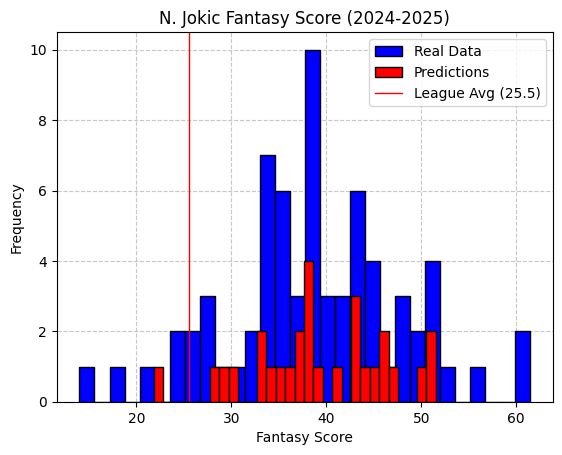

In [60]:
# Create a figure and an Axes object
fig, ax = plt.subplots()

# Plot the histogram
ax.hist(season_data['fantasy_score'], bins=30, edgecolor='black', zorder=2, label='Real Data', color='blue') # Give the histogram a zorder > 0
ax.hist(predictions, bins=30, edgecolor='black', zorder=2, label='Predictions', color='red')

# Add the grid with a lower zorder to place it behind the histogram
ax.grid(True, linestyle='--', alpha=0.7, zorder=0)

# Add a vertical line at 25.5
ax.axvline(25.5, color='red', linestyle='-', linewidth=1, label="League Avg (25.5)")

# Add labels and title for clarity
ax.set_xlabel("Fantasy Score")
ax.set_ylabel("Frequency")
ax.set_title("N. Jokic Fantasy Score (2024-2025)")

# Add legend
ax.legend()

# Display the plot
plt.show()

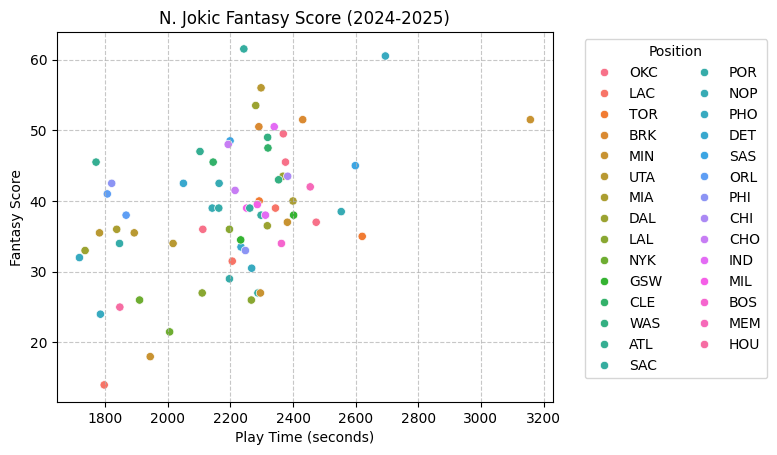

In [15]:
fig, ax = plt.subplots()

sns.scatterplot(data=season_data, x='MP', y='fantasy_score', hue='Opp')

# Add the grid with a lower zorder to place it behind the histogram
ax.grid(True, linestyle='--', alpha=0.7, zorder=0)

# Add labels and title for clarity
ax.set_ylabel("Fantasy Score")
ax.set_xlabel("Play Time (seconds)")
ax.set_title("N. Jokic Fantasy Score (2024-2025)")

# Add legend
ax.legend(title="Position", bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2)

plt.show()

In [85]:
# predict_win(player, opp_team)

nba_teams = [
    "ATL", "BOS", "BRK", "CHI", "CLE", "DAL", "DET", 
    "GSW", "HOU", "IND", "LAC", "LAL", "MEM", "MIA", "MIL", 
    "MIN", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", 
    "SAC", "SAS", "TOR", "UTA", "WAS", "CHO"
]

test_data = season_data.drop(
    columns=['Date', 'double_double', 'triple_double', 'fantasy_score', 'Percent Score', 'Player_NAME']
)

# for team in nba_teams:
#     test_data[test_data[team] == 1]

test_data = test_data[test_data['ATL'] == 1]

games = []
for row in test_data.index:
    curr_data = test_data.loc[row]

    url = curr_data['URL']
    team = curr_data['Team']
    opp = curr_data['Opp']

    game_data = get_game_data(team, opp, url)
    games.append(game_data)
    
    den_roster = get_roster('DEN', '2025')
    atl_roster = get_roster('ATL', '2025')

Error fetching URL: Not Found
Attempt 1 failed on: https://www.basketball-reference.com/boxscores/202412080DEN.html

Attemping reconnection at: https://www.basketball-reference.com/boxscores/202412080ATL.html


Success




In [87]:
game_one_team

,player,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,fta,...,drb,trb,ast,stl,blk,tov,pf,pts,game_score,plus_minus
0,Michael Porter Jr.,35:45,12,17,.706,1,5,.200,1,1,...,5,7,3,0,0,1,2,26,22.1,+15
1,Nikola Jokić,35:03,17,29,.586,3,6,.500,11,13,...,11,14,8,3,0,3,2,48,43.9,+25
2,Christian Braun,32:12,7,11,.636,2,2,1.000,1,2,...,6,8,4,2,1,1,3,17,18.2,+34
3,Russell Westbrook,30:42,4,6,.667,1,3,.333,0,1,...,1,1,11,2,1,4,3,9,11.5,+12
4,Aaron Gordon,22:53,1,6,.167,0,4,.000,4,5,...,2,2,6,0,1,3,1,6,3.9,+17
5,Julian Strawther,21:40,5,6,.833,3,4,.750,0,0,...,2,2,3,0,0,3,3,13,9.3,-2
6,Peyton Watson,18:02,1,2,.500,0,1,.000,0,1,...,1,1,0,1,2,0,3,2,2.1,+9
7,Jalen Pickett,17:18,2,2,1.000,1,1,1.000,0,0,...,2,2,5,1,0,2,4,5,5.9,+18
8,DeAndre Jordan,10:07,2,2,1.000,0,0,,0,0,...,4,4,2,0,0,1,0,4,5.0,0
9,Hunter Tyson,7:48,2,2,1.000,1,1,1.000,0,0,...,1,1,1,0,0,0,1,5,5.0,+7


In [117]:
game_one_team = games[0][0]
game_one_opp = games[0][1]
game_one = test_data.iloc[0].to_frame().T

den_stats = (
    pd
    .merge(
        game_one_team, 
        den_roster, 
        left_on='player', 
        right_on='Player_NAME', 
        how='inner'
    )
    .drop(columns=['Player_NAME'])
)
den_stats['Result'] = 1
atl_stats = (
    pd
    .merge(
        game_one_opp, 
        atl_roster, 
        left_on='player', 
        right_on='Player_NAME', 
        how='inner'
    )
    .drop(columns=['Player_NAME'])
)
atl_stats['Result'] = 0

stats = pd.concat([den_stats, atl_stats], axis=0)

def time_to_secs(time_str):
        if type(time_str) == float:
            return
        
        minutes, seconds = map(int, time_str.split(":"))
        total_seconds = minutes * 60 + seconds  

        return total_seconds

# stats = stats.fillna('')
stats['mp'] = stats['mp'].apply(time_to_secs)
stats


,player,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,ft,fta,...,blk,tov,pf,pts,game_score,plus_minus,Player_POSITION,Player_TEAM,Result,reason
0,Michael Porter Jr.,2145.0,12,17,.706,1,5,.200,1,1,...,0,1,2,26,22.1,+15,SF,DEN,1,NaN
1,Nikola Jokić,2103.0,17,29,.586,3,6,.500,11,13,...,0,3,2,48,43.9,+25,C,DEN,1,NaN
2,Christian Braun,1932.0,7,11,.636,2,2,1.000,1,2,...,1,1,3,17,18.2,+34,SG,DEN,1,NaN
3,Russell Westbrook,1842.0,4,6,.667,1,3,.333,0,1,...,1,4,3,9,11.5,+12,PG,DEN,1,NaN
4,Aaron Gordon,1373.0,1,6,.167,0,4,.000,4,5,...,1,3,1,6,3.9,+17,PF,DEN,1,NaN
5,Julian Strawther,1300.0,5,6,.833,3,4,.750,0,0,...,0,3,3,13,9.3,-2,SG,DEN,1,NaN
6,Peyton Watson,1082.0,1,2,.500,0,1,.000,0,1,...,2,0,3,2,2.1,+9,SF,DEN,1,NaN
7,Jalen Pickett,1038.0,2,2,1.000,1,1,1.000,0,0,...,0,2,4,5,5.9,+18,SG,DEN,1,NaN
8,DeAndre Jordan,607.0,2,2,1.000,0,0,,0,0,...,0,1,0,4,5.0,0,C,DEN,1,NaN
9,Hunter Tyson,468.0,2,2,1.000,1,1,1.000,0,0,...,0,0,1,5,5.0,+7,PF,DEN,1,NaN


In [53]:
# test_data = season_data.drop(
#     columns=['Date', 'Team', 'Opp', 'double_double', 'triple_double', 'fantasy_score', 'Percent Score', 'URL', 'Player_NAME']
# )

# test_data = test_data[[col for col in test_data.columns if '%' not in col]]
# played_against = test_data.iloc[:,23:].columns

# y = test_data['Result'].values
# X = test_data.drop(columns='Result').values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# logreg = LogisticRegression()

# logreg.fit(X_train_scaled, y_train)

# logreg.score(X_test_scaled, y_test)

In [8]:
# ### make the alpha model for each model equal to the correct alpha

# predictions = []
# for i in range(len(models)):
#     curr_model = models.iloc[i]

#     feature = curr_model['Feature']
#     model = curr_model['Model']
#     alpha = curr_model['Alphas']

#     if type(alpha) == float:
#         pred = model.predict() ###
#         predictions.append(pred)
#         continue

#     model.set_params(alpha=alpha)
#     pred = model.predict() ###

In [7]:
# curr_team = season_data['Team'][0]

# nba_teams = [
#     "ATL", "BOS", "BRK", "CHI", "CLE", "DAL", "DEN", "DET", 
#     "GSW", "HOU", "IND", "LAC", "LAL", "MEM", "MIA", "MIL", 
#     "MIN", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", 
#     "SAC", "SAS", "TOR", "UTA", "WAS", "CHO"
# ]

# nba_teams.remove(curr_team)

# to_remove = [
#     'Date', 'Opp', 'URL', 'Player_NAME', 'double_double', 'triple_double', 
#     'Team', 'fantasy_score', 'Result' # result is classification
# ]

# to_remove_with_teams = to_remove + nba_teams
# to_remove = season_data.drop(columns=to_remove).columns.to_list()

# features_to_model = season_data.drop(columns=to_remove_with_teams).columns.to_list()

# models = []
# scores = []
# alphas = []
# predictions = []
# for feature in features_to_model:
#     X = season_data[to_remove].drop(columns=f'{feature}').values
#     y = season_data[f'{feature}'].values

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
#     scaler = StandardScaler()

#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     linreg = LinearRegression()
#     linreg.fit(X_train_scaled, y_train)

#     linreg_score = linreg.score(X_test_scaled, y_test) 

#     alpha_vals = [0.1, 1.0, 10.0, 100.0, 1000.0]

#     ridge_scores = []
#     for alpha in alpha_vals:
#         ridge = Ridge(alpha=alpha)
#         ridge.fit(X_train_scaled, y_train)
#         ridge_scores.append(ridge.score(X_test_scaled, y_test))

#     lasso_scores = []
#     for alpha in alpha_vals:
#         ridge = Lasso(alpha=alpha)
#         ridge.fit(X_train_scaled, y_train)
#         lasso_scores.append(ridge.score(X_test_scaled, y_test))

#     scores_list = [[LinearRegression(), np.nan, linreg_score]] + \
#     [[Ridge(), alpha, score] for alpha, score in zip(alpha_vals, ridge_scores)] + \
#     [[Lasso(), alpha, score] for alpha, score in zip(alpha_vals, lasso_scores)]

#     model_selection_df = (
#         pd
#         .DataFrame(scores_list, columns=['model', 'alpha', 'score'])
#         .sort_values('score', ascending=False)
#     )

#     model_selection_df = model_selection_df[model_selection_df['score'] != 1]

#     final_model_data = model_selection_df.iloc[0]
#     final_model = final_model_data['model']
#     final_alpha = final_model_data['alpha']

#     if type(final_alpha) == float:
#         final_model.set_params(alpha=final_alpha)

#     final_model.fit(X_train_scaled, y_train)

#     y_pred = final_model.predict(X_test)

#     predictions.append(y_pred)
#     models.append(final_model)
#     scores.append(final_model_data['score'])
#     alphas.append(final_alpha)

# final_models = pd.DataFrame({
#     'Feature': features_to_model,
#     'Model': models,
#     'Score': scores,
#     'Alphas': alphas,
#     'Predictions': predictions
# })

# final_models['Predictions'] = final_models['Predictions'].apply(lambda x: x.sum())

# season_data[to_remove]

In [27]:
5405 / 60

90.08333333333333

In [25]:
season_data[features_to_model].mean()

MP               2081.957143
FG                  7.528571
FGA                12.757143
FG%                 0.592029
3P                  0.928571
3PA                 2.228571
3P%                 0.364029
2P                  6.600000
2PA                10.528571
2P%                 0.617186
eFG%                0.633314
FT                  3.114286
FTA                 4.128571
FT%                 0.674800
ORB                 3.814286
DRB                10.071429
TRB                13.885714
AST                 6.042857
STL                 0.685714
BLK                 0.371429
TOV                 2.885714
PF                  3.271429
PTS                19.100000
GmSc               19.448571
+/-                 2.071429
Team Score        116.057143
Opp Score         115.042857
Percent Score       0.165000
dtype: float64

In [15]:
10277.175400 / 60

171.28625666666667

From chatgpt:

"So, based on publicly available league-average stats and your scoring model, 
the typical NBA starter in the 2024–25 season likely averaged around 25.5 
fantasy points per game.

If you have data on specific starters’ per-game stats, you could compute their 
individual fantasy scores more precisely!"

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [ ]:
def model_feature(feature):
    X = season_data.drop(columns=[
        'Date', 'Opp', f'{feature}', 'URL', 'Player_NAME', 'TRB', 'AST', 'PTS', 
        'TOV', 'STL', 'BLK', 'double_double', 'triple_double'
    ]).values
    y = season_data[[f'{feature}']].values

    scaler = StandardScaler()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    linreg = LinearRegression()
    linreg.fit(X_train_scaled, y_train)

    linreg_score = linreg.score(X_test_scaled, y_test) # 0.47934832060435195

    alpha_vals = [0.1, 1.0, 10.0, 100.0, 1000.0]

    ridge_scores = []
    for alpha in alpha_vals:
        ridge = Ridge(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)
        ridge_scores.append(ridge.score(X_test_scaled, y_test))

    lasso_scores = []
    for alpha in alpha_vals:
        ridge = Lasso(alpha=alpha)
        ridge.fit(X_train_scaled, y_train)
        lasso_scores.append(ridge.score(X_test_scaled, y_test))

    scores_list = [[LinearRegression(), np.nan, linreg_score]] + \
    [[Ridge(), alpha, score] for alpha, score in zip(alpha_vals, ridge_scores)] + \
    [[Lasso(), alpha, score] for alpha, score in zip(alpha_vals, lasso_scores)]

    model_selection_df = (
        pd
        .DataFrame(scores_list, columns=['model', 'alpha', 'score'])
        .sort_values('score', ascending=False)
    )

    final_model_data = model_selection_df.iloc[0]
    final_model = final_model_data['model']
    final_alpha = final_model_data['alpha']

    if type(final_alpha) == float:
        final_model.set_params(alpha=final_alpha)

    final_model.fit(X_train_scaled, y_train)

    print(f'Modeling Data for: {feature}')

    return final_model, final_model_data['score']

In [7]:
model_feature('fantasy_score')

Modeling Data for: fantasy_score


,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [8]:
season_data.columns

Index(['Date', 'Opp', 'Result', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-', 'Team Score',
       'Opp Score', 'Percent Score', 'URL', 'Player_NAME', 'ATL', 'BOS', 'BRK',
       'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL',
       'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO',
       'POR', 'SAS', 'TOR', 'UTA', 'WAS', 'CHO', 'double_double',
       'triple_double', 'fantasy_score'],
      dtype='object')

In [ ]:
features_to_model = season_data.drop(columns=[
    'Date', 'Opp', 'URL', 'Player_NAME', 'TRB', 'AST', 'PTS', 
    'TOV', 'STL', 'BLK', 'double_double', 'triple_double', 'ATL', 'BOS', 'BRK',
       'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL',
       'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO',
       'POR', 'SAS', 'TOR', 'UTA', 'WAS', 'CHO', 'fantasy_score'
]).columns.to_list()

models = {}
for feature in features_to_model:
    model = model_feature(feature)
    models[feature] = model[0]
    models[f'{feature} score'] = model[1]

Modeling Data for: Result
Modeling Data for: MP
Modeling Data for: FG
Modeling Data for: FGA
Modeling Data for: FG%
Modeling Data for: 3P
Modeling Data for: 3PA
Modeling Data for: 3P%
Modeling Data for: 2P
Modeling Data for: 2PA
Modeling Data for: 2P%
Modeling Data for: eFG%
Modeling Data for: FT


C:\Users\DerDo\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.467e+05, tolerance: 9.271e+02
  model = cd_fast.enet_coordinate_descent(


Modeling Data for: FTA
Modeling Data for: FT%
Modeling Data for: ORB
Modeling Data for: DRB
Modeling Data for: PF
Modeling Data for: GmSc
Modeling Data for: +/-
Modeling Data for: Team Score
Modeling Data for: Opp Score
Modeling Data for: Percent Score
Modeling Data for: fantasy_score


In [ ]:
features_to_model.pop()

'fantasy_score'

In [31]:
coefs = models['fantasy_score'].coef_
plotting = {'features': features_to_model, 'coef': coefs}

len(coefs)
len(features_to_model)

23

In [18]:
models

{'Result': Lasso(),
 'Result score': np.float64(0.4216030601407259),
 'MP': Ridge(),
 'MP score': np.float64(-0.649443338276376),
 'FG': LinearRegression(),
 'FG score': np.float64(1.0),
 'FGA': LinearRegression(),
 'FGA score': np.float64(1.0),
 'FG%': LinearRegression(),
 'FG% score': np.float64(0.9564459688379208),
 '3P': LinearRegression(),
 '3P score': np.float64(1.0),
 '3PA': LinearRegression(),
 '3PA score': np.float64(1.0),
 '3P%': Ridge(),
 '3P% score': np.float64(0.6411593718578078),
 '2P': LinearRegression(),
 '2P score': np.float64(1.0),
 '2PA': LinearRegression(),
 '2PA score': np.float64(1.0),
 '2P%': Ridge(),
 '2P% score': np.float64(0.7442053183139079),
 'eFG%': Ridge(),
 'eFG% score': np.float64(0.9587280713260773),
 'FT': Lasso(),
 'FT score': np.float64(0.9256474163366317),
 'FTA': Lasso(),
 'FTA score': np.float64(0.8398648162864656),
 'FT%': Lasso(),
 'FT% score': np.float64(-0.12484408940935121),
 'ORB': Ridge(),
 'ORB score': np.float64(0.0818763420018791),
 'DRB

In [35]:
features_to_model = season_data.drop(columns=[
    'Date', 'Opp', 'URL', 'Player_NAME', 'TRB', 'AST', 'PTS', 
    'TOV', 'STL', 'BLK', 'double_double', 'triple_double', 'ATL', 'BOS', 'BRK',
       'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL',
       'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO',
       'POR', 'SAS', 'TOR', 'UTA', 'WAS', 'CHO', 'fantasy_score'
]).columns.to_list()

for feature in features_to_model:
    X = season_data.drop(columns=[
        'Date', 'Opp', f'{feature}', 'URL', 'Player_NAME', 'TRB', 'AST', 'PTS', 
        'TOV', 'STL', 'BLK', 'double_double', 'triple_double', 'fantasy_score'
    ]).values
    y = season_data[[f'{feature}']].values



In [ ]:
sea